# Predicting store sales values using Rossmann dataset

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rdm
from sklearn.metrics import accuracy_score

In [40]:
#Reading the variables into a specific data types
types_train = {'Sales': np.int32,
               'Store': np.int32,
               'DayOfWeek': np.int32,
               'Date': str,
               'Customers': np.int32,
               'Open': bool,
               'Promo': bool,
               'StateHoliday': str,
               'SchoolHoliday': bool}

#Parsing the Date column into DateTime Object
df_train = pd.read_csv('train.csv', dtype=types_train, parse_dates=['Date'])
df_train.dtypes

Store                     int32
DayOfWeek                 int32
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                       bool
Promo                      bool
StateHoliday             object
SchoolHoliday              bool
dtype: object

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64


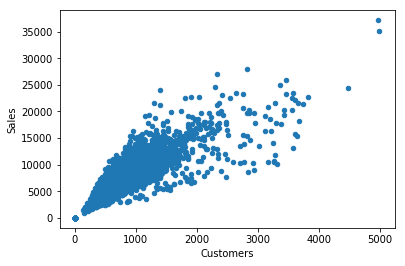

In [72]:
#Showing the linear relationship between Sales and Customers
print(df_train['Customers'].describe())
subs_idx = rdm.sample(range(len(df_train)), 8000)
df_subset = pd.concat([df_train['Sales'], df_train['Customers']], axis=1).iloc[subs_idx]
df_subset.plot.scatter(x='Customers', y='Sales')

## Linear Regression using single feature (Customer)

In [42]:
#Creating and fitting data to the model
from sklearn import linear_model

#Cast to numpy for scikit-learn and only take the non-trivial datapoints
ar_data = df_train[df_train['Open'] == True].as_matrix(columns=['Sales', 'Customers'])
print(len(ar_data))

# Take 20% of randomly chosen datapoints for evaluation
n = len(ar_data)
np.random.shuffle(ar_data)
amnt_eval = int(np.round(0.2*n))
print(amnt_eval)
train_set = ar_data[amnt_eval:]
eval_set = ar_data[:amnt_eval]
print(train_set[:, 1])
# Train the model
linregr = linear_model.LinearRegression()
linregr.fit(X=train_set[:, 1].reshape(-1, 1), y=train_set[:, 0])

844392
168878
[544 783 582 ... 493 641 557]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
#Predicting Sales value and calculating RMSPE 
eval_y_pred = linregr.predict(eval_set[:, 1].reshape(-1, 1))
def rmspe(ar_pred, ar_truth):
    """
    Calculates the root mean square percentage error. Any entries with a truth value of 0 are ignored
    """
    nonzero_idx = np.nonzero(ar_truth)
    ar_pred = ar_pred[nonzero_idx]
    ar_truth = ar_truth[nonzero_idx]
    spe = np.power(np.divide(np.subtract(ar_pred, ar_truth), ar_truth), 2)
    return np.sqrt(spe.mean())


print("RMSPE: {0:0.3f}".format(rmspe(eval_y_pred, eval_set[:, 0])))

accuracy = linregr.score(eval_set[:, 1].reshape(-1, 1),  eval_set[:, 0], sample_weight=None)
print ("Accuracy using Linear Regression is : %.2f%%" % (accuracy * 100.0))

RMSPE: 0.285
Accuracy using Linear Regression is : 67.68%


In [44]:
types_store = {'Store': np.int32,
               'StoreType': str,
               'Assortment': str,
               'CompetitionDistance': str, # cant use int here, some cells are empty
               'CompetitionOpenSinceMonth': str,
               'CompetitionOpenSinceYear': str,
               'Promo2': bool,
               'Promo2SinceWeek': str,
               'Promo2SinceYear': str,
               'PromoInterval': str}
df_store = pd.read_csv('store.csv',
                       dtype=types_store)
print('Amount of rows: ' + str(len(df_store)))    
print('Missing values? ' + str(df_store.isnull().values.any()))
df_store.dtypes

Amount of rows: 1115
Missing values? True


Store                         int32
StoreType                    object
Assortment                   object
CompetitionDistance          object
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                         bool
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

## Data cleaning

In [76]:
#Replacing '' values with nan values
df_store.replace('', np.nan, inplace=True)
df_store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [46]:
# Replace missing values at 'CompetitionDistance' with the median of that column.
comp_dist_avg = df_store[~df_store['CompetitionDistance'].isnull()]['CompetitionDistance'].astype(np.float32).median()
print('Median distance to competitors: ' + str(comp_dist_avg))
comp_dist_avg = int(np.round(comp_dist_avg))
df_store['CompetitionDistance'].replace(np.nan, str(comp_dist_avg), inplace=True)
df_store['CompetitionDistance'] = df_store['CompetitionDistance'].astype(np.int32)
df_store.dtypes

Median distance to competitors: 2325.0


Store                         int64
StoreType                    object
Assortment                   object
CompetitionDistance           int32
CompetitionOpenSinceMonth    object
CompetitionOpenSinceYear     object
Promo2                         bool
Promo2SinceWeek              object
Promo2SinceYear              object
PromoInterval                object
dtype: object

Finding meanfull replacements for the columns "CompetitionOpenSinceMonth/Year' is more difficult. Lets have a closer look at these variables and if they actually influence the sales.

In [48]:
df_comps = df_store[~df_store['CompetitionOpenSinceYear'].isnull()][['Store', 'CompetitionOpenSinceYear']]
df_comps = df_comps.astype(np.int32)
df_comps.describe()

,Store,CompetitionOpenSinceYear
count,761.000000,761.000000
mean,556.797635,2008.668857
std,322.605611,6.195983
min,1.000000,1900.000000
25%,281.000000,2006.000000
50%,570.000000,2010.000000
75%,831.000000,2013.000000
max,1112.000000,2015.000000


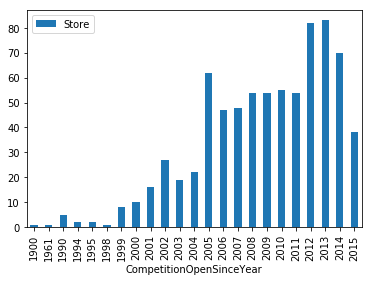

In [49]:
df_comps.groupby(['CompetitionOpenSinceYear']).count().plot.bar()

1900 is an outlier. It probably also doesnt make a difference if a competitor opened 20 or 30 years ago, so we can think about simplifying the data by unifying all pre-2000 datapoints. But lets see the relationship with the sales first.

In [50]:
df_comps = df_store[~df_store['CompetitionOpenSinceYear'].isnull()]
df_comps = df_comps.astype(dtype={'CompetitionOpenSinceYear': np.int32,
                       'CompetitionOpenSinceMonth': np.int32})
df_merge = pd.merge(df_train[['Store','Sales']], df_comps, how = 'inner', on = 'Store')
df_merge = df_merge.groupby('Store').agg(np.mean)
df_merge.corr(method='pearson')

,Sales,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
Sales,1.000000,-0.048979,-0.052453,0.018893,-0.176585
CompetitionDistance,-0.048979,1.000000,-0.059126,0.025124,-0.140708
CompetitionOpenSinceMonth,-0.052453,-0.059126,1.000000,-0.052250,-0.011485
CompetitionOpenSinceYear,0.018893,0.025124,-0.052250,1.000000,-0.076520
Promo2,-0.176585,-0.140708,-0.011485,-0.076520,1.000000


We aggregated over different dates using the mean, so sales contains the average sale per day for a certain store. The other values are simply the corresponding values for each store. We dont really see any high correlation values here. Suprisingly, Promo2 seems to have a negativ effect on the sales.

Lets just replace the missing values with 0 for now, one-hot encode the categorical features and get our complete dataset.

In [51]:
df_store.replace(np.nan, 0, inplace=True)
df_store.drop('PromoInterval', axis = 1)
df_store = df_store.astype(dtype={'CompetitionOpenSinceYear': np.int32,
                       'CompetitionOpenSinceMonth': np.int32})
df_merge = pd.merge(df_train, df_comps, how = 'inner', on = 'Store')
df_merge['Assortment'] = pd.Categorical(df_merge['Assortment']).codes
df_merge['StoreType'] = pd.Categorical(df_merge['StoreType']).codes
df_merge = df_merge.drop(labels=['Date'], axis=1)
df_merge=df_merge.fillna(value=0)
df_merge.describe()

,Store,DayOfWeek,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
count,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000,693861.000000
mean,556.501521,3.998350,5780.898006,633.288927,1.146443,0.852266,5414.271057,7.222866,2008.690228
std,322.512188,1.997392,3874.982491,455.927727,1.347344,0.986967,7832.744154,3.211832,5.992644
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.000000,1900.000000
25%,281.000000,2.000000,3680.000000,401.000000,0.000000,0.000000,720.000000,4.000000,2006.000000
50%,569.000000,4.000000,5743.000000,613.000000,0.000000,0.000000,2230.000000,8.000000,2010.000000
75%,833.000000,6.000000,7890.000000,845.000000,3.000000,2.000000,6470.000000,10.000000,2013.000000
max,1112.000000,7.000000,38722.000000,7388.000000,3.000000,2.000000,58260.000000,12.000000,2015.000000


# Model training and evaluation

## Linear regression using multiple feature

In [58]:
df_merge = df_merge[df_merge['Open'] == True]
# Reorder so that the target variable is at first position
df_merge.head()
cols = list(df_merge.columns.values)
cols.remove('Sales')
cols.remove('Store')
cols.remove('Open')
cols.remove('PromoInterval')
cols = ['Sales'] + cols
df_merge_sub = df_merge[cols]
#Cast to numpy for scikit-learn
df_merge_sub = df_merge_sub.head(300)
ar_data = df_merge_sub.as_matrix()
# Take 20% of randomly chosen datapoints for evaluation
n = len(ar_data)
np.random.shuffle(ar_data)
amnt_eval = int(np.round(0.2*n))
train_set = ar_data[amnt_eval:]
eval_set = ar_data[:amnt_eval]
# Train the model
linregr = linear_model.LinearRegression()
linregr.fit(X=train_set[:, 1:], y=train_set[:, 0])
# Make predictions using the testing set
eval_y_pred = linregr.predict(eval_set[:, 1:])
print("RMSPE: %.3f" % rmspe(eval_y_pred, eval_set[:, 0]))

accuracy = linregr.score(eval_set[:, 1:],  eval_set[:, 0], sample_weight=None)
print ("Accuracy using Linear Regression is : %.2f%%" % (accuracy * 100.0))

RMSPE: 0.070
Accuracy using Linear Regression is : 87.58%


## Ensemble Model (Bagging Regressor)

In [71]:
from sklearn import decomposition
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
#Cast to numpy for scikit-learn
ar_data = df_merge_sub.as_matrix()
n = len(ar_data)
print('Available datapoints: ' + str(n))
# Split target variable from rest, apply PCA
np.random.shuffle(ar_data)
print(ar_data)
X=ar_data[:, 1:] 
y=ar_data[:, 0]
# Take 20% of randomly chosen datapoints for evaluation
amnt_eval = int(np.round(0.2*n))
X_train = X[amnt_eval:]
X_eval = X[:amnt_eval]
y_train = y[amnt_eval:]
y_eval = y[:amnt_eval]
# Train the model
svr_ensemble = BaggingRegressor(base_estimator=SVR(kernel='linear', C=100, degree=2, epsilon=10, tol=1),
                                n_estimators=10,
                                max_samples=100,
                                max_features=5,
                                bootstrap=False,
                                n_jobs=-1,
                                verbose=100)
                                
svr_ensemble.fit(X=X_train, y=y_train)
# Make predictions using the testing set
eval_y_pred = svr_ensemble.predict(X_eval)

print(eval_y_pred[0:10])
print(y_eval[0:10])
print(y[0:10])

print("RMSPE: %.3f" % rmspe(eval_y_pred, y_eval))

accuracy = svr_ensemble.score(X_eval, y_eval, sample_weight=None)

print ("Accuracy using Bagging Regressor is : %.2f%%" % (accuracy * 100.0))

Available datapoints: 300
[[4901 2 596 ... False 0 0]
 [4726 5 630 ... False 0 0]
 [4852 2 503 ... False 0 0]
 ...
 [4161 5 512 ... False 0 0]
 [4019 6 463 ... False 0 0]
 [5023 6 645 ... False 0 0]]
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 13), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 13), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 13), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    4.2s
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 13), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=8)]: D

Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(99,), dtype=int32).
Pickling array (shape=(99, 5), dtype=float64).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(1, 99), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(100,), dtype=int32).
Pickling array (shape=(100, 5), dtype=float64).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(1, 100), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(5,), dtype=int32).
Pickling array (shape=(5,), dtype=int32).
Pickling array (shape=(60, 13), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(

## Bagging Regressor with PCA (Principle Component Analysis)

In [70]:
from sklearn import decomposition
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
#Cast to numpy for scikit-learn
ar_data = df_merge_sub.as_matrix()
n = len(ar_data)
print('Available datapoints: ' + str(n))
# Split target variable from rest, apply PCA
np.random.shuffle(ar_data)
print(ar_data)
X=ar_data[:, 1:] 
y=ar_data[:, 0]
pca = decomposition.PCA(n_components=5)
pca.fit(X)
X = pca.transform(X)
# Take 20% of randomly chosen datapoints for evaluation
amnt_eval = int(np.round(0.2*n))
X_train = X[amnt_eval:]
X_eval = X[:amnt_eval]
y_train = y[amnt_eval:]
y_eval = y[:amnt_eval]
# Train the model
svr_ensemble = BaggingRegressor(base_estimator=SVR(kernel='linear', C=100, degree=2, epsilon=10, tol=1),
                                n_estimators=10,
                                max_samples=100,
                                max_features=5,
                                bootstrap=False,
                                n_jobs=-1,
                                verbose=100)
                                
svr_ensemble.fit(X=X_train, y=y_train)
# Make predictions using the testing set
eval_y_pred = svr_ensemble.predict(X_eval)

print(eval_y_pred[0:10])
print(y_eval[0:10])
print(y[0:10])

print("RMSPE: %.3f" % rmspe(eval_y_pred, y_eval))

accuracy = svr_ensemble.score(X_eval, y_eval, sample_weight=None)

print ("Accuracy using Bagging Regressor is : %.2f%%" % (accuracy * 100.0))

Available datapoints: 300
[[4611 1 545 ... False 0 0]
 [3317 5 420 ... False 0 0]
 [4346 4 507 ... False 0 0]
 ...
 [3681 2 476 ... False 0 0]
 [5384 5 609 ... False 0 0]
 [3346 3 414 ... False 0 0]]
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 5), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 5), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 5), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    3.8s
Pickling array (shape=(10,), dtype=int32).
Pickling array (shape=(240, 5), dtype=float64).
Pickling array (shape=(240,), dtype=object).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=8)]: Done 

Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(97,), dtype=int32).
Pickling array (shape=(97, 5), dtype=float64).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(1, 97), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(98,), dtype=int32).
Pickling array (shape=(98, 5), dtype=float64).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(1, 98), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(5,), dtype=int32).
Pickling array (shape=(5,), dtype=int32).
Pickling array (shape=(60, 5), dtype=float64).
Pickling array (shape=(0,), dtype=float64).
Pickling array (shape=(100,

## Random forest regressor

In [19]:
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor
X=ar_data[:, 1:] 
y=ar_data[:, 0]
# Take 20% of randomly chosen datapoints for evaluation
amnt_eval = int(np.round(0.2*n))
X_train = X[amnt_eval:]
X_eval = X[:amnt_eval]
y_train = y[amnt_eval:]
y_eval = y[:amnt_eval]
# Train the model
forest = RandomForestRegressor(n_estimators=27, n_jobs=-1)
                                
forest.fit(X=X_train, y=y_train)
# Make predictions using the testing set
eval_y_pred = forest.predict(X_eval)

print("RMSPE: %.3f" % rmspe(eval_y_pred, y_eval))

accuracy = forest.score(X_eval, y_eval, sample_weight=None)
print ("Accuracy using Random Forest Classifier is : %.2f%%" % (accuracy * 100.0))

RMSPE: 0.068
Accuracy using Random Forest Classifier is : 91.24%


<table>
<tbody>
<tr>
    <td><B>Model</B></td>
    <td><B>RMSPE</B></td>
    <td><B>Accuracy</B></td>
</tr>
<tr>
<td>Linear Regression with a single feature</td>
<td>0.285</td>
<td>67.68%</td>
</tr>
<tr>
<td>Linear Regression with multiple features</td>
<td>0.070</td>
<td>87.58%</td>
</tr>
<tr>
<td>Bagging Regressor</td>
<td>0.128</td>
<td>53.24%</td>
</tr>
<tr>
<td>Bagging Regressor with PCA&nbsp;</td>
<td>0.052</td>
<td>95.75%</td>
</tr>
<tr>
<td>Random forest classifier</td>
<td>0.068</td>
<td>91.24%</td>
</tr>
</tbody>
</table>

<h2>References</h2>
<ul>
    <p>Notebooks references</p>
    <li>https://github.com/SuyashLakhotia/RossmannStoreSales</li>
    <li>https://github.com/cutd/Rossmann-Store-Sales</li>
    
    <p>Bagging Regressor</p>
    <li>https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/</li>
    <li>http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html</li>
</ul>